In [8]:
import random
import os
import gdown
import json
import pickle
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('wordnet')

# Cargar el archivo intents.json
intents = json.loads(open('intents.json').read())


[nltk_data] Downloading package punkt to
[nltk_data]     /home/josepablo98/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/josepablo98/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Archivos
glove_file = 'glove.6B.200d.txt'
word2vec_file = 'glove.6B.200d.word2vec.txt'
url = 'https://drive.google.com/uc?id=1IRQMsvbPEy62Djob9FUkVzmO9DmC4rPa'

# Descargar archivo GloVe si no existe
if not os.path.exists(glove_file):
    print(glove_file + " no encontrado. Descargando desde Drive...")
    gdown.download(url, glove_file, quiet=False)
else:
    print(glove_file + " ya existe.")

# Convertir GloVe a Word2Vec si no existe el archivo convertido
if not os.path.exists(word2vec_file):
    print("Convirtiendo " + glove_file + " a formato Word2Vec...")
    glove2word2vec(glove_file, word2vec_file)
    print("Conversión completa.")
else:
    print(word2vec_file + " ya existe.")

# Cargar embeddings Word2Vec
print("Cargando embeddings...")
word_vectors = KeyedVectors.load_word2vec_format(word2vec_file, binary=False)
print("Embeddings cargados correctamente.")


glove.6B.200d.txt ya existe.
glove.6B.200d.word2vec.txt ya existe.
Cargando embeddings...
Embeddings cargados correctamente.


In [10]:
# Preparar palabras, clases y documentos
words = []
classes = []
documents = []
ignore_letters = ['?', '!', '¿', '.', ',']

for intent in intents['intents']:
    for pattern in intent['patterns']:
        word_list = nltk.word_tokenize(pattern)
        words.extend(word_list)
        documents.append((word_list, intent["tag"]))
        if intent["tag"] not in classes:
            classes.append(intent["tag"])

words = sorted(set([lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]))

# Crear dataset de entrenamiento
training = []
output_empty = [0] * len(classes)

def get_embedding_vector(word):
    """Obtiene el vector del embedding para una palabra, o un vector de ceros si no está en el vocabulario."""
    if word in word_vectors:
        return word_vectors[word]
    else:
        return np.zeros(word_vectors.vector_size)

for document in documents:
    bag = np.mean([get_embedding_vector(lemmatizer.lemmatize(word.lower())) for word in document[0]], axis=0)
    if bag.shape == ():  # Caso donde no hay embeddings válidos
        bag = np.zeros(word_vectors.vector_size)
    output_row = list(output_empty)
    output_row[classes.index(document[1])] = 1
    training.append([bag, output_row])

random.shuffle(training)

train_x = np.array([entry[0] for entry in training])
train_y = np.array([entry[1] for entry in training])

pickle.dump(classes, open('classes.pkl', 'wb'))
pickle.dump(words, open('words.pkl', 'wb'))

In [ ]:
# Crear modelo neuronal
model = Sequential()
model.add(Dense(512, input_shape=(word_vectors.vector_size,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compilar el modelo
sgd = SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(train_x, train_y, epochs=6000, batch_size=64, verbose=1)

# Guardar el modelo entrenado
model.save("chatbot_embeddings.h5")


In [6]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Función para graficar el historial de entrenamiento de un modelo (history de model.fit).
    Argumentos:
        history: objeto History que contiene los valores de entrenamiento y validación.
    """
    # Graficar la pérdida de entrenamiento y validación
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Pérdida de validación')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Graficar la precisión de entrenamiento y validación
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Precisión de validación')
    plt.title('Precisión durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    plt.tight_layout()
    plt.show()


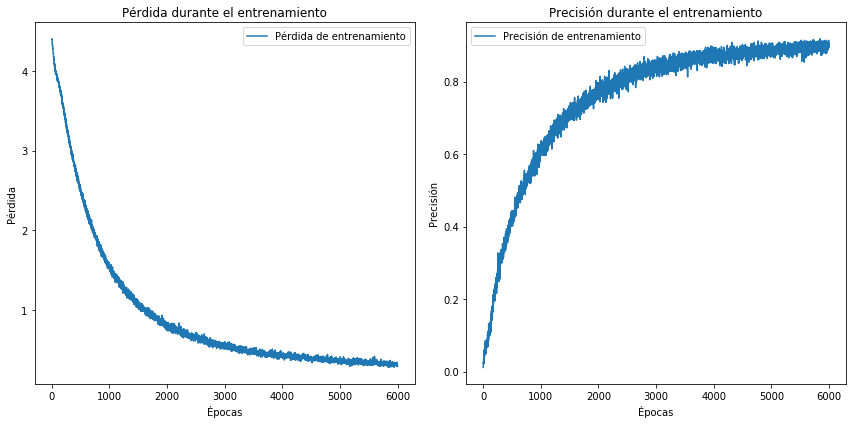

In [7]:
plot_training_history(history)